# X Posts Sentiment Analysis
> The goal of our "X posts Sentiment Analysis project" is to build a reliable model that classifies tweets as positive, negative Using time-series models like RNN or LSTM trained on Sentiment140 dataset, we’ll extract insights from X posts to inform marketing, product development, and brand management.

Team Members:
- Aws Alharthi
- Naif Alaklubi
- Ismail Alsalhi
- Ali Alfares
- Layan AlShahrani
- Lama Aljuaid

# Connect To Google Drive (Ignore this if you are working locally)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "drive/MyDrive/sentiment140.zip"

Archive:  drive/MyDrive/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


# Imports

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import warnings
warnings.filterwarnings('ignore')                              # Turn the warnings off.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Dataset

## Reading the dataset

In [4]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df.shape

(1600000, 6)

In [33]:
# choose the text and target columns only
data = df[[5, 0]]

In [34]:
print(data.shape)
display(data.head())

(1600000, 2)


,5,0
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [35]:
data = data.rename(columns={5: 'text', 0:'class'})
data.head()

,text,class
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [36]:
data['class'].value_counts()

,count
class,
0,800000
4,800000


In [37]:
data.isnull().sum()

,0
text,0
class,0


## Sampling (50,000 samples from each class)

In [38]:
n = data.loc[data['class']== 0] # negative samples
p = data.loc[data['class']== 4] # positive samples

n = n.sample(n=50000, random_state=2024)
p = p.sample(n=50000, random_state=2024)

# concatenating
data = pd.concat([n, p], ignore_index=True)

(100000, 2)
class
0    50000
4    50000
Name: count, dtype: int64


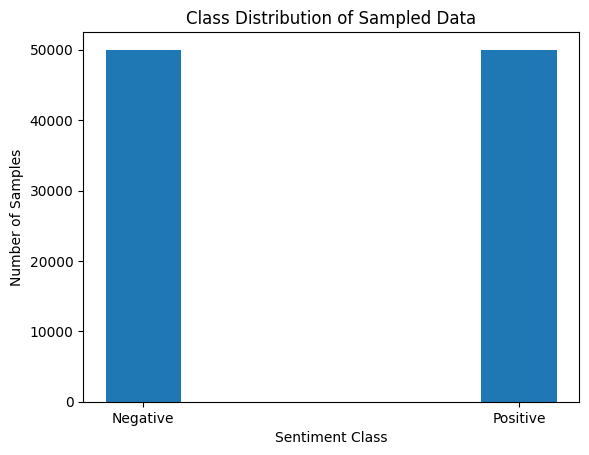

In [39]:
print(data.shape)
print(data['class'].value_counts())

class_dist = data['class'].value_counts()

plt.bar(class_dist.index, class_dist.values)
plt.xticks([0, 4], ['Negative', 'Positive'])
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of Sampled Data')
plt.show()


# Data Pre-Processing

## Text cleaning

In [40]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower()

    # remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # remove mentions
    text = re.sub(r'@\w+', '', text)

    # remove # (we will keep the words)
    text = re.sub(r'#', '', text)

    # remove special characters, numbers, ...
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # remove whitespace
    # text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # remove english stop words
    words = [word for word in word_tokenize(text) if word not in stop_words] # word_tokenize(text) will generate a list of tokenized sample

    # lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)



data['text'] = data['text'].apply(clean_text)
data.head()

,text,class
0,next weekend miss,0
1,yep bedroom flat cost k dont enough penny one,0
2,happy father day daddy miss dad today year ago...,0
3,let get two since want doberman,0
4,parent well sister alone house lonely people b...,0


## Data splitting
> splitted data (tokenized and padded)

In [90]:
X = data['text']
y = data['class']
y = y.replace(4, 1)

# training (80%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=2024)

# validation (10%) and test (10%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2024)

# tokenization
max_words = 1000  # vocab size
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

# add padding
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_valid = pad_sequences(X_valid, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

In [91]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(80000, 50) (80000,)
(10000, 50) (10000,)
(10000, 50) (10000,)


# Models

## Hyperparams
> can be modified

In [105]:
embedding_dim = 256
lstm_units = 256
dropout_rate = 0.6

lr = 0.001
optimizer = Adam(learning_rate=lr)
epochs = 20
batch_size = 64

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

## 1

In [106]:
model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

# LSTM layers (stacked)
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))  # Bidirectional LSTM
model.add(Dropout(dropout_rate))

# second LSTM layer
model.add(LSTM(lstm_units))
model.add(Dropout(dropout_rate))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)             │ (None, 50, 256)             │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 50, 512)             │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,127,105 (8.11 MB)

 Trainable params: 2,127,105 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:

filename = f"emb{embedding_dim}_lstm{lstm_units}_dropout{str(dropout_rate).replace('.', '_')}_lr{str(lr).replace('.', '_')}.keras"
print(filename)


checkpoint = ModelCheckpoint(
    filename,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)


emb256_lstm256_dropout0_6_lr0_001.keras
Epoch 1/20
1250/1250 - 28s - 22ms/step - accuracy: 0.7506 - loss: 0.5147 - val_accuracy: 0.7471 - val_loss: 0.5126
Epoch 2/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7542 - loss: 0.5039 - val_accuracy: 0.7304 - val_loss: 0.5305
Epoch 3/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7594 - loss: 0.4962 - val_accuracy: 0.7433 - val_loss: 0.5223
Epoch 4/20
1250/1250 - 41s - 33ms/step - accuracy: 0.7651 - loss: 0.4855 - val_accuracy: 0.7458 - val_loss: 0.5090
